# Webscraping Using Selenium & BeautifulSoup
---

The Dutch outdoor women's field hockey national team is the reigning European, World, and Olympic champion, and has been for years at a time. With 5 Olympic titles, 9 World Cup wins, and 13 EuroHockey golds, this team is the most successful field hockey team in history.

Source: [Netherlands women's national field hockey team Wikipedia](https://en.wikipedia.org/wiki/Netherlands_women%27s_national_field_hockey_team)

## 1. Scraping

### 1.1. Navigating to the webpage

In [1]:
# Import packages
from selenium import webdriver
from chromedriver_autoinstaller import install
install(True)
from selenium.webdriver.common.by import By
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.chrome.options import Options

from selenium.common.exceptions import NoSuchElementException
from selenium.common.exceptions import ElementClickInterceptedException
from selenium.common.exceptions import ElementNotInteractableException

from bs4 import BeautifulSoup

import time, re, requests
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [2]:
# Open the browser without showing it on screen
opts = Options()
opts.add_argument("--headless=new")
opts.add_argument("window-size=2560,1600")

# Open the Chrome browser
driver = webdriver.Chrome(options=opts)

# Navigate to the International Hockey Federation homepage
url = "https://www.fih.hockey/"
driver.get(url)

# Set the implicit waiting time to 0.5 seconds
driver.implicitly_wait(0.5)

In [3]:
# Set the explicit waiting time to 20 seconds
wait = WebDriverWait(driver, 20)

In [4]:
try:
    # Reject data usage
    do_not_consent_btn = wait.until(EC.element_to_be_clickable((By.CSS_SELECTOR, ".fc-cta-do-not-consent")))
    do_not_consent_btn.click()
except:
    pass

try:
    # Close popup
    close_popup_button = wait.until(EC.element_to_be_clickable((By.CSS_SELECTOR, ".btn-close")))
    close_popup_button.click()
except:
    pass

In [5]:
# Find the navigation bar links
nav_bar = driver.find_elements(By.CSS_SELECTOR, ".nav-anchor")
if nav_bar:
    for link in nav_bar:
        # Print the navigation bar links
        print(link.text, link.get_attribute("href"))

FIH Pro League https://www.fih.hockey/events/fih-pro-league
Medical/Anti-Doping https://www.fih.hockey/about-fih/anti-doping-and-medical
Our Documents https://www.fih.hockey/about-fih/official-documents
Rankings https://www.fih.hockey/outdoor-hockey-rankings
News https://www.fih.hockey/news
Events https://www.fih.hockey/events
Matches https://www.fih.hockey/schedule-fixtures-results
Videos https://www.fih.hockey/videos


In [6]:
# Navigate to the Rankings webpage
rankings_tab = driver.find_element(By.CSS_SELECTOR, "a[title='Rankings']")
rankings_tab.click()

In [7]:
# Pause execution for 5 seconds
time.sleep(5)

In [8]:
# Show the Women teams' ranking table
women_ranking = driver.find_element(By.XPATH, '//*[@id="f68ba7c4-2099-405f-b95a-16f6c7ac326e"]/div/div/div[1]/div/div/ul/li[2]')
women_ranking.click()

In [9]:
# Pause execution for 5 seconds
time.sleep(5)

In [10]:
# Find the rows of the table body
ranking = driver.find_elements(By.CSS_SELECTOR, ".table-body .table-row")

women_ranking_table = []
if ranking:
    for row in ranking:
        # Print the table row links
        print(row.get_attribute("href"))
        # Append the links to the list
        women_ranking_table.append(row.get_attribute("href"))

https://www.fih.hockey/outdoor-rankings/netherlands-women-hockey-rankings-48
https://www.fih.hockey/outdoor-rankings/argentina-women-hockey-rankings-3
https://www.fih.hockey/outdoor-rankings/belgium-women-hockey-rankings-9
https://www.fih.hockey/outdoor-rankings/china-women-hockey-rankings-14
https://www.fih.hockey/outdoor-rankings/spain-women-hockey-rankings-21
https://www.fih.hockey/outdoor-rankings/australia-women-hockey-rankings-4
https://www.fih.hockey/outdoor-rankings/germany-women-hockey-rankings-28
https://www.fih.hockey/outdoor-rankings/england-women-hockey-rankings-20
https://www.fih.hockey/outdoor-rankings/new-zealand-women-hockey-rankings-50
https://www.fih.hockey/outdoor-rankings/india-women-hockey-rankings-35
https://www.fih.hockey/outdoor-rankings/japan-women-hockey-rankings-39
https://www.fih.hockey/outdoor-rankings/united-states-women-hockey-rankings-74
https://www.fih.hockey/outdoor-rankings/ireland-women-hockey-rankings-37
https://www.fih.hockey/outdoor-rankings/scot

In [11]:
# Navigate to the Dutch Outdoor Women's Field Hockey National Team webpage
driver.get(''.join([team for team in women_ranking_table if 'netherlands-women' in team]))

### 1.2. Defining Functions

In [12]:
def change_year(change_to_year):
    """
    Change the table year from the dropdown menu.

    Parameters:
        Change_to_year (str): Year to select from the table dropdown menu.
    
    Returns:
        Table with values of the year selected from the year selection dropdown menu.
    """
    # Expand the year selection dropdown menu
    driver.find_element(By.XPATH, '//*[@id="4623167a-6fe7-41f2-8150-5bdf74fb783b"]/div/div/div[2]/div/section/div[2]/div[1]/div[2]').click()
    # Select the year from the year selection dropdown menu
    return driver.find_element(By.XPATH, change_to_year).click()

In [13]:
def scrape_rows():
    """
    Scrape the rows from the table of a specific year.

    Returns:
        dict: Scraped table row values.
    """
    # Load Selenium's page_source into BeautifulSoup
    document = BeautifulSoup(driver.page_source, "html.parser")

    return {
        "dates": document.select(".table-body .date"),
        "comp_types": document.select(".table-body .competition"),
        "comps": document.select(".table-body .table-row-bottom .row-body .sub-title"),
        "opps": document.select(".table-body .team-wrap .full-name"),
        "nl_scores": document.select(".team-info-a .score"),
        "opp_scores": document.select(".team-info-b .score"),
        "results": document.select(".table-body .table-row-bottom .row-body .middle .info-item:nth-child(2) .info-value"),
        "before_pts": document.select(".table-body .points-before"),
        "after_pts": document.select(".table-body .points-exchanged"),
        "pt_differences": document.select(".table-body .points-exchanged")
    }

In [14]:
def create_text():
    """
    Turn the scraped rows into text.

    Returns:
        dict: Table row values in text form.
    """
    # Assign scrape_rows() function to scrape_rows_result variable
    scrape_rows_result = scrape_rows()
    # Find the table year
    actual_year = driver.find_element(By.XPATH, '//*[@id="4623167a-6fe7-41f2-8150-5bdf74fb783b"]/div/div/div[2]/div/section/div[2]/div[1]/div[2]/div[1]/p').text

    return {
        "actual_year": actual_year,
        "date_text": [date.text for date in scrape_rows_result["dates"]],
        "comp_type_text": [comp_type.text for comp_type in scrape_rows_result["comp_types"]],
        "comp_text": [comp.text for comp in scrape_rows_result["comps"]],
        "opp_text": [opp.text for opp in scrape_rows_result["opps"]],
        "nl_score_text": [nl_score.text for nl_score in scrape_rows_result["nl_scores"]],
        "opp_score_text": [opp_score.text for opp_score in scrape_rows_result["opp_scores"]],
        "result_text": [result.text for result in scrape_rows_result["results"]],
        "before_pt_text": [before_pt.text for before_pt in scrape_rows_result["before_pts"]],
        "after_pt_text": [after_pt.text for after_pt in scrape_rows_result["after_pts"]],
        "pt_difference_text": [pt_difference.text for pt_difference in scrape_rows_result["pt_differences"]]
    }

In [15]:
def collect_data():
    """
    Iterates over table rows and scrapes it's content.
    
    Returns:
        List: Non-emtpy table rows.
    """
    # Assign create_text() function to create_text_result variable
    create_text_result = create_text()
    # Count the amount of table rows
    row_count = len(driver.find_elements(By.CSS_SELECTOR, ".table-body .table-row"))
    
    # Append text to list
    specific_year = []
    row_index = 0
    for row in range(row_count):
        specific_year.append({
            "date": create_text_result["date_text"][row_index] + " " + create_text_result["actual_year"],
            "competition_type": create_text_result["comp_type_text"][row_index],
            "competition": create_text_result["comp_text"][row_index],
            "netherlands_score": create_text_result["nl_score_text"][row_index],
            "opponent_score": create_text_result["opp_score_text"][row_index],
            "opponent": create_text_result["opp_text"][row_index],
            "result": create_text_result["result_text"][row_index],
            "points_before_match": create_text_result["before_pt_text"][row_index],
            "points_after_match": float(create_text_result["after_pt_text"][row_index]) + float(create_text_result["before_pt_text"][row_index]),
            "point_difference": create_text_result["pt_difference_text"][row_index]
        })
        row_index += 1

    return specific_year

In [16]:
def scrape_year(change_to_year):
    """
    Runs the change_year() and collect_data() functions.
    
    Parameters:
        Change_to_year (str): Year to select from the table year selection dropdown menu.
    
    Returns:
        List: Non-emtpy table rows.
    """
    # Run the change_year() function
    change_year(change_to_year)
    
    return collect_data()

### 1.3. Creating Pandas DataFrame

In [17]:
# Pause execution for 5 seconds
time.sleep(5)

In [18]:
# Expand the year selection dropdown menu
wait.until(EC.element_to_be_clickable((By.XPATH, '//*[@id="4623167a-6fe7-41f2-8150-5bdf74fb783b"]/div/div/div[2]/div/section/div[2]/div[1]/div[2]'))).click()
# Count the amount of rows in the year selection dropdown menu
year_dropdown_length = len(driver.find_elements(By.CSS_SELECTOR, ".option-box2 .active .select-list .list-item"))
# Collapse the year selection dropdown menu
wait.until(EC.element_to_be_clickable((By.XPATH, '//*[@id="4623167a-6fe7-41f2-8150-5bdf74fb783b"]/div/div/div[2]/div/section/div[2]/div[1]/div[2]'))).click()

# Instantiate the df_nl_women DataFrame
df_nl_women = pd.DataFrame()
# Iterate through the years of the year selection dropdown menu
for year in range(year_dropdown_length):
    # XPATH which updates the index of the year to select in the year selection dropdown menu
    change_to_year = f'//*[@id="4623167a-6fe7-41f2-8150-5bdf74fb783b"]/div/div/div[2]/div/section/div[2]/div[1]/div[2]/div[2]/div/button[{year + 1}]'
    # Create the df_append DataFrame, based on the results of the scrape_year() function
    df_append = pd.DataFrame(scrape_year(change_to_year))
    # Concatenate the df_append DataFrame to the df_nl_women DataFrame
    df_nl_women = pd.concat([df_nl_women, df_append], ignore_index=True)

# Show the df_nl_women DataFrame
df_nl_women

,date,competition_type,competition,netherlands_score,opponent_score,opponent,result,points_before_match,points_after_match,point_difference
0,12 Dec 2025,FIH Pro League,2025-26 FIH Hockey Pro League (W),5,1,Germany,Win (10),3809.84,3809.84,0
1,11 Dec 2025,FIH Pro League,2025-26 FIH Hockey Pro League (W),4,0,Argentina,Win (10),3781.77,3809.83,28.06
2,09 Dec 2025,FIH Pro League,2025-26 FIH Hockey Pro League (W),2,0,Germany,Win (10),3781.77,3781.77,0
3,17 Aug 2025,Continental Championship,EuroHockey Championship 2025 Women,2,1,Germany,Win (10),3781.77,3781.77,0
4,15 Aug 2025,Continental Championship,EuroHockey Championship 2025 Women,3,1,Spain,Win (10),3781.77,3781.77,0
...,...,...,...,...,...,...,...,...,...,...
113,16 Feb 2020,FIH Pro League,2020-21 FIH Hockey Pro League (W),3,1,Argentina,Win (10),3398.02,3426.03,28.01
114,15 Feb 2020,FIH Pro League,2020-21 FIH Hockey Pro League (W),0,2,Argentina,Lose (10),3478.00,3398.02,-79.98
115,26 Jan 2020,FIH Pro League,2020-21 FIH Hockey Pro League (W),9,0,United States,Win (10),3478.00,3478.00,0
116,12 Jan 2020,FIH Pro League,2020-21 FIH Hockey Pro League (W),4,2,China,Win (10),3478.00,3478.00,0


## 2. Cleaning

In [19]:
# Use Regex to remove the (10) or (5) from the values in the result column
df_nl_women['result'] = df_nl_women['result'].replace(to_replace=r'\s?\((10|5)\)', value='', regex=True)

# Show the df_nl_women DataFrame
df_nl_women

,date,competition_type,competition,netherlands_score,opponent_score,opponent,result,points_before_match,points_after_match,point_difference
0,12 Dec 2025,FIH Pro League,2025-26 FIH Hockey Pro League (W),5,1,Germany,Win,3809.84,3809.84,0
1,11 Dec 2025,FIH Pro League,2025-26 FIH Hockey Pro League (W),4,0,Argentina,Win,3781.77,3809.83,28.06
2,09 Dec 2025,FIH Pro League,2025-26 FIH Hockey Pro League (W),2,0,Germany,Win,3781.77,3781.77,0
3,17 Aug 2025,Continental Championship,EuroHockey Championship 2025 Women,2,1,Germany,Win,3781.77,3781.77,0
4,15 Aug 2025,Continental Championship,EuroHockey Championship 2025 Women,3,1,Spain,Win,3781.77,3781.77,0
...,...,...,...,...,...,...,...,...,...,...
113,16 Feb 2020,FIH Pro League,2020-21 FIH Hockey Pro League (W),3,1,Argentina,Win,3398.02,3426.03,28.01
114,15 Feb 2020,FIH Pro League,2020-21 FIH Hockey Pro League (W),0,2,Argentina,Lose,3478.00,3398.02,-79.98
115,26 Jan 2020,FIH Pro League,2020-21 FIH Hockey Pro League (W),9,0,United States,Win,3478.00,3478.00,0
116,12 Jan 2020,FIH Pro League,2020-21 FIH Hockey Pro League (W),4,2,China,Win,3478.00,3478.00,0


## 3. Visualizations & Analysis

In [20]:
# Copy the df_nl_women DataFrame
df_visuals = df_nl_women.copy()

# Show the df_visuals DataFrame
df_visuals.head()

,date,competition_type,competition,netherlands_score,opponent_score,opponent,result,points_before_match,points_after_match,point_difference
0,12 Dec 2025,FIH Pro League,2025-26 FIH Hockey Pro League (W),5,1,Germany,Win,3809.84,3809.84,0
1,11 Dec 2025,FIH Pro League,2025-26 FIH Hockey Pro League (W),4,0,Argentina,Win,3781.77,3809.83,28.06
2,09 Dec 2025,FIH Pro League,2025-26 FIH Hockey Pro League (W),2,0,Germany,Win,3781.77,3781.77,0
3,17 Aug 2025,Continental Championship,EuroHockey Championship 2025 Women,2,1,Germany,Win,3781.77,3781.77,0
4,15 Aug 2025,Continental Championship,EuroHockey Championship 2025 Women,3,1,Spain,Win,3781.77,3781.77,0


In [21]:
# Turn the df_visuals['date'] column into datetime format
df_visuals['date'] = pd.to_datetime(df_visuals['date'])
# Turn the df_visuals['netherlands_score'] column into an int
df_visuals['netherlands_score'] = df_visuals['netherlands_score'].astype(int)
# Turn the df_visuals['opponent_score'] column into an int
df_visuals['opponent_score'] = df_visuals['opponent_score'].astype(int)

# Show the df_visuals DataFrame
df_visuals.head()

,date,competition_type,competition,netherlands_score,opponent_score,opponent,result,points_before_match,points_after_match,point_difference
0,2025-12-12,FIH Pro League,2025-26 FIH Hockey Pro League (W),5,1,Germany,Win,3809.84,3809.84,0
1,2025-12-11,FIH Pro League,2025-26 FIH Hockey Pro League (W),4,0,Argentina,Win,3781.77,3809.83,28.06
2,2025-12-09,FIH Pro League,2025-26 FIH Hockey Pro League (W),2,0,Germany,Win,3781.77,3781.77,0
3,2025-08-17,Continental Championship,EuroHockey Championship 2025 Women,2,1,Germany,Win,3781.77,3781.77,0
4,2025-08-15,Continental Championship,EuroHockey Championship 2025 Women,3,1,Spain,Win,3781.77,3781.77,0


### 3.1. Specific Goal Amounts

,netherlands_freq,opponent_freq
specific_goal_amounts,,
0,1,43
1,13,54
2,22,18
3,32,3
4,14,0
5,14,0
6,9,0
7,6,0
8,2,0


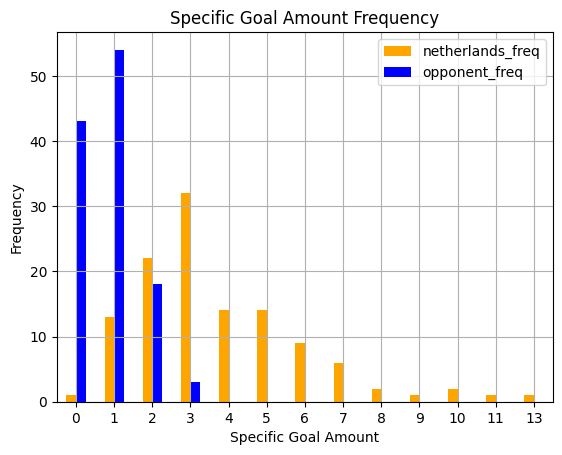

In [22]:
# Count the amount of specific goal amounts
goals_nl = df_visuals['netherlands_score'].value_counts()
goals_opp = df_visuals['opponent_score'].value_counts()

# Create a pandas DataFrame based on the amount of specific goal amounts
df_value_counts = goals_nl.rename_axis('specific_goal_amounts').to_frame('netherlands_freq').sort_index()
# Create the opponent_freq column
df_value_counts['opponent_freq'] = goals_opp
# In the opponent_freq column turn NaN values into 0 and turn floats into int
df_value_counts['opponent_freq'] = df_value_counts['opponent_freq'].fillna(0).astype(int)

# Plot a bar chart of the df_value_counts DataFrame
df_value_counts.plot(
    y=["netherlands_freq", "opponent_freq"], # Select which columns of the df_value_counts DataFrame to plot
    kind="bar", # Make the type of plot a bar plot
    rot=0, # Rotate the numbers on the x-axis so they are the not turned 90 degrees counterclockwise
    color=["orange", "blue"], # Pick the colors of the bars
    title="Specific Goal Amount Frequency", # create the title
    xlabel="Specific Goal Amount", # Create the label on the x-axis
    ylabel="Frequency", # Create the label on the y-axis
    grid=True # Add a grid
)

# Show the df_value_counts DataFrame
df_value_counts

Based on the DataFrame and the visualizations, it is clear that the Dutch women's field hockey team is not only strong in offense with scores going as high as 13, but also in defence, with 1 goal against occuring the most, 0 being the runners up by far, and 3 being the most that anyone between 2020 and 2025 had ever scored against them.

### 3.2. Match Results

,frequency
match_result,
Win,104
Shootout Win,7
Lose,5
Shootout Lose,2


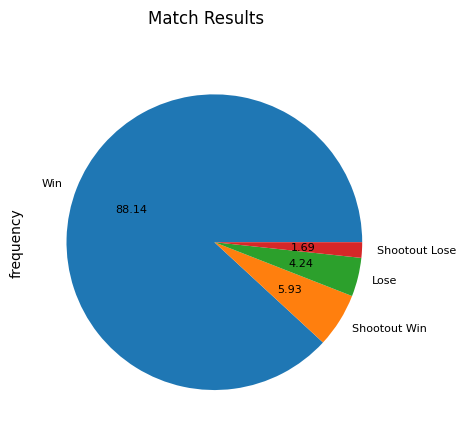

In [23]:
# Count the amount of specific match results
results = df_visuals['result'].value_counts()

# Create a pandas DataFrame based on the amount of specific match results
df_results = results.rename_axis('match_result').to_frame('frequency')

# Plot a pie chart of the df_results DataFrame
df_results.plot(
    subplots=True, # Create subplots
    kind="pie", # Make the type of plot a pie chart
    autopct="%.2f", # Set the percentage to 2 decimals
    legend=False, # Do not show the legend
    title="Match Results", # Create the title
    textprops={"fontsize":8} # Set the fontsize to 8
)

# Show the df_value_counts DataFrame
df_results

The 111 wins or a win percentage of 94.07% shows an almost perfect track record. Based on these stats, one could argue that it was almost inevitable for them not to be anything but the reigning number 1. However, to be completely sure, I would suggest future research to examine the other countries wins and losses as well.

Moreover, if one happens to be a fan of this team, then these stats may bring up certain negative emotions, considering in 2016 they lost the Olympic finale because of shootouts. Afterwards, many Dutch legends of the sport retired, and the 2016 Olympics were supposed to be their last hurrah. On the other hand, it may just mean that they have improved quite a lot since then, and that losing that finale was a wake up call for the team and the field hockey world, that they are in fact not invincible after all.

### 3.3. Points After Match

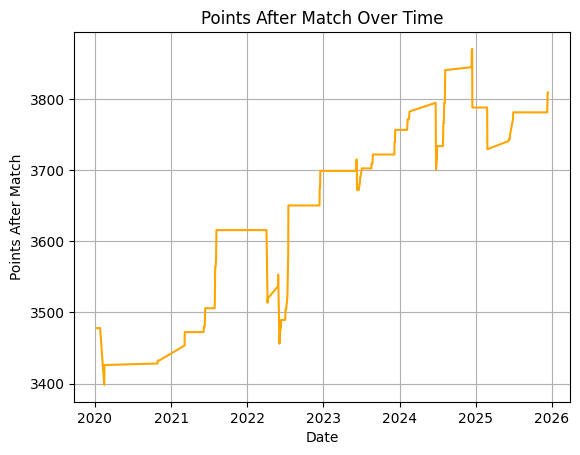

In [24]:
# Plot a linegraph of the Points After Match column
plt.plot(df_visuals["date"], df_visuals["points_after_match"], color="orange") # Select which columns to plot and what color the line should be
plt.xlabel("Date") # Create the label on the x-axis
plt.ylabel("Points After Match") # Create the label on the y-axis
plt.title("Points After Match Over Time") # Create a title
plt.grid() # Add a grid

The graph shows that the amount of points that the Dutch women's team is worth after a match, has kept increasing over the years. To draw specific conclusions from this, I would suggest future research to be done into the other countries' points after matches, and what the trends are of those countries.

## 4. Saving as a CSV File

In [25]:
# Save the df_nl_women DataFrame as a CSV file
df_nl_women.to_csv('nl_women_fih.csv', index=False, encoding='utf-8')